In [1]:
import re
import string
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy import displacy
from spacy.pipeline import merge_entities

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances

from corextopic import corextopic as ct
from corextopic import vis_topic as vt


In [2]:
df = pd.read_csv('movie_summaries.csv', index_col=0)


In [3]:
# remove digits from docs
df['summary'] = df['summary'].str.replace('\d+', ' ', regex=True)


# Baseline Topic Models

In [4]:
def make_topics(docs, vectorizer, topic_modeler, n_words=15):
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-n_words-1:-1]]
        print(f'Topic {idx}:\n', ', '.join(top_words), '\n')
    
    return doc_word_vectors, doc_topic_vectors


In [5]:
def token_formatter(token, doc_entities):
    
    token_text = token.lemma_.lower().strip().replace('star ', '')
    
    if 'academy award' in token.text.lower():
        return 'academy award'
        
    elif token.text in doc_entities:
        token_string = re.sub(f'[{string.punctuation}]+', ' ', token_text).strip().lower()
        return re.sub(r'\s+', ' ', token_string)
        
    elif token.pos_ == 'PROPN':
        token_string = re.sub(f'[{string.punctuation}]+', ' ', token_text).strip().lower()
        return re.sub(r'\s+', ' ', token_string)
    
    else:
        return token.lemma_.lower().strip()
            

In [6]:
def spacy_tokenizer(spacy_doc):
        
    ent_list = ['DATE', 'CARDINAL', 'ORDINAL', 'MONEY']
        
    doc_entities = [ent.text for ent in spacy_doc.ents if (ent.label_ not in ent_list)]
    ignore_ents = [ent.text for ent in spacy_doc.ents if (ent.label_ in ent_list)]
    
    # remove stop words, parts of speech, and punctuation
    pos_list = ['SPACE', 'PUNCT', 'SYM']
    puncs = string.punctuation.replace('+','_')

    doc_tokens = [token for token in spacy_doc if (not token.is_stop) and (token.lemma_ not in nlp.Defaults.stop_words) and (token.pos_ not in pos_list) and (not any(p in token.text for p in puncs)) and (token.text not in ignore_ents)]

    # lemmatize each token and convert to lowercase if POS is not a proper noun
    doc_tokens = [token_formatter(token, doc_entities) for token in doc_tokens if len(token) > 2]

    return doc_tokens


In [7]:
def plot_top_words(model, feature_names, n_words, title, rows=2, cols=5):

    if str(type(model)) == "<class 'corextopic.corextopic.Corex'>":
        fig, axes = plt.subplots(rows, cols, figsize=(30, 15), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic_words in enumerate(model.get_topics(n_words=n_words)):
            top_features = [word[0] for word in topic_words]
            weights = [word[1] for word in topic_words]
            
            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)
    
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(30, 15), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

## CountVectorizer, NMF, 10 topic model

In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.01)
topic_modeler = NMF(10, max_iter=1000, random_state=42)

doc_word_vectors, doc_topic_vectors = make_topics(docs, vectorizer, topic_modeler);


In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, NMF, 10 topic model')

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_vectors.round(5),
                             index = df['title'])
doc_topic_df

## TfidfVectorizer, NMF, 10 topic model

In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = TfidfVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.01)
topic_modeler = NMF(10, max_iter=1000, random_state=42)

doc_word_vectors, doc_topic_vectors = make_topics(docs, vectorizer, topic_modeler);


In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Tfidf, NMF, 10 topic model')

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_vectors.round(5),
                             index = df['title'])
doc_topic_df

## CountVectorizer, CorEx, 10 topic model


In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.01, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=10, words=words, seed=42)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
    

In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, Corex, 10 topic model')

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show();


## TfidfVectorizer, TruncatedSVD, 10 topic model

In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = TfidfVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.01)
topic_modeler = TruncatedSVD(n_components=10, random_state=42)

doc_word_vectors, doc_topic_vectors = make_topics(docs, vectorizer, topic_modeler);


In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Tfidf, SVD, 10 topic model')

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_vectors.round(5),
                             index = df['title'])
doc_topic_df

## CountVectorizer, CorEx, 10 topic model, lower min_df, removed words from vocaulary


In [21]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', \
                            'widescreen', 'studio', 'movie', 'scene', 'effect', 'screenplay'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.001, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=10, words=words, seed=42)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
    

0: cartoon, touchstone, star, world, place, los angeles, discover, new york, donald, cinemascope
1: base, find, educational, life, picture, love, young, family, old, father
2: disney, score, original, london, premiere, provide, classic, action, animator, early
3: voice, new, friend, character, create, evil, save, king, dvd, good
4: feature, academy award, song, nominate, symphony, silly, animate, academy, award, musical
5: journey, truth, survive, unlikely, incredible, risk, alaska, forever, wild, legend
6: time, true, adventure, face, captain, burbank, build, look, use, white
7: work, artist, process, right, great, hollywood, stage, program, initial, designer
8: high, coach, game, double, murder, bill, kidnap, race, crime, competition
9: try, run, fall, chase, away, home, steal, stay, cat, owner


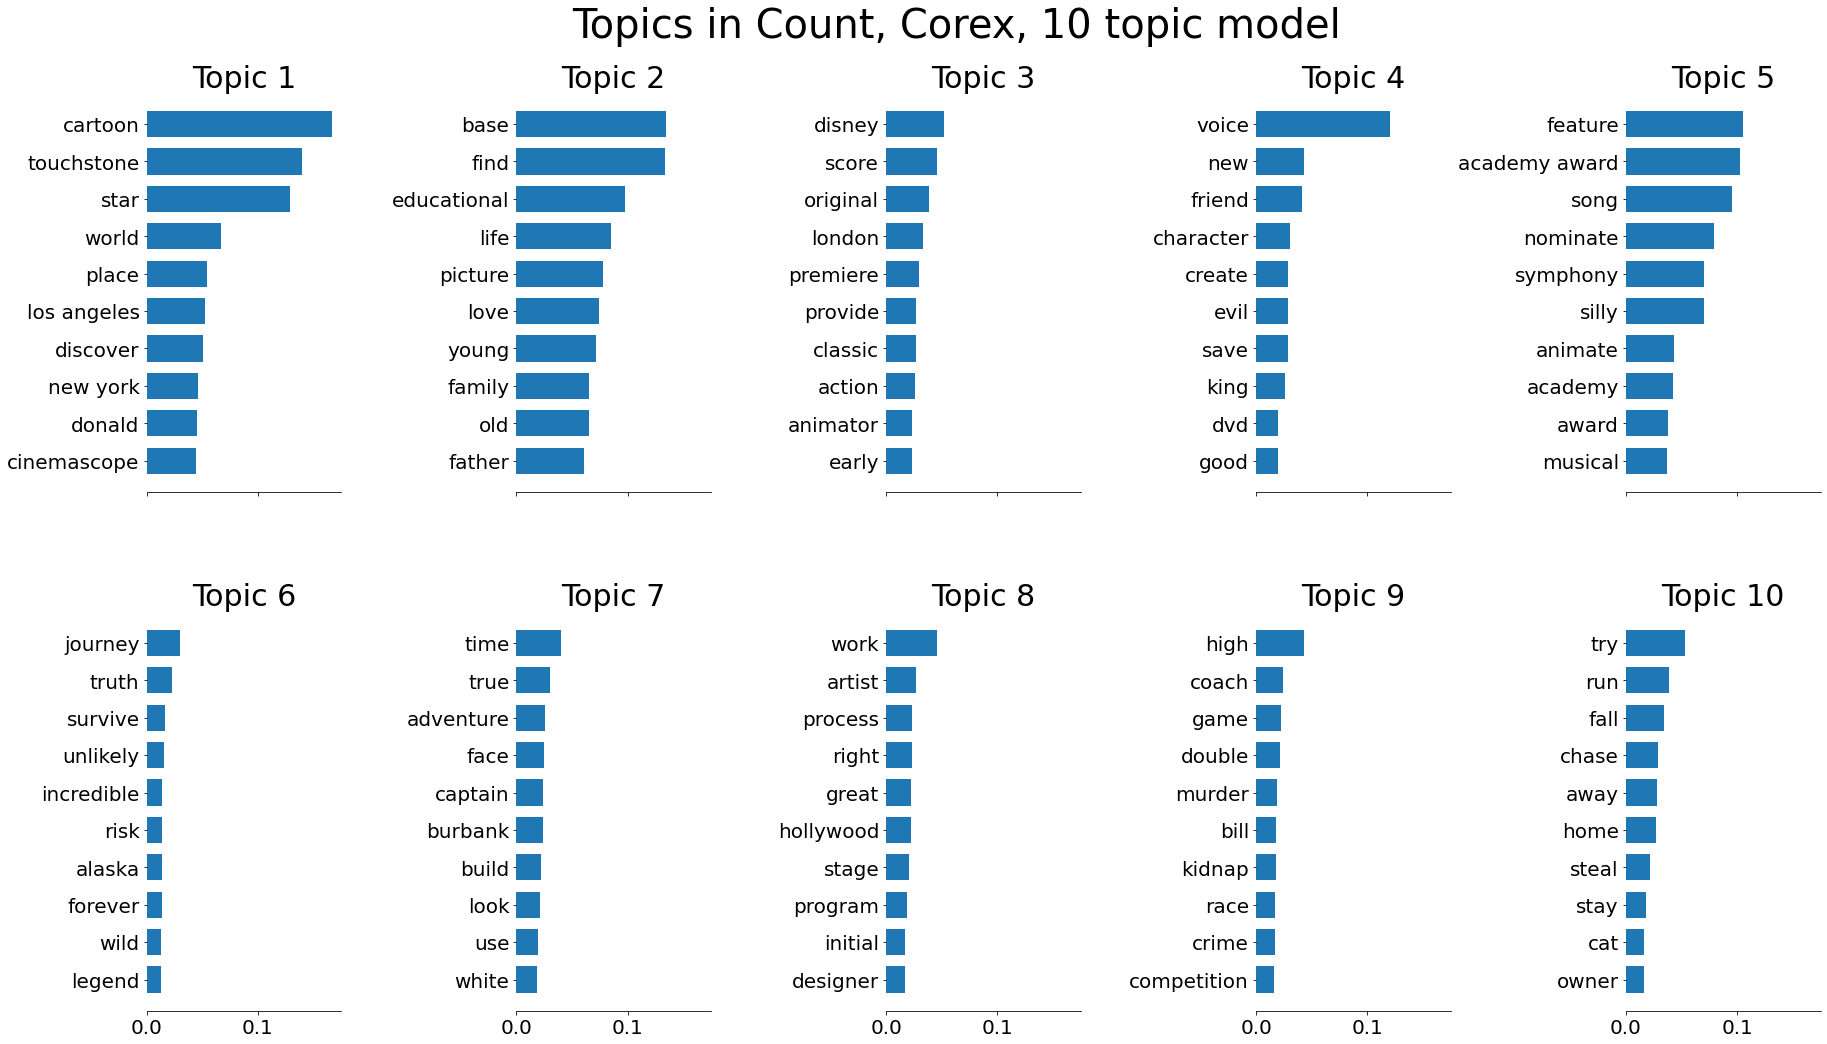

In [22]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, Corex, 10 topic model')

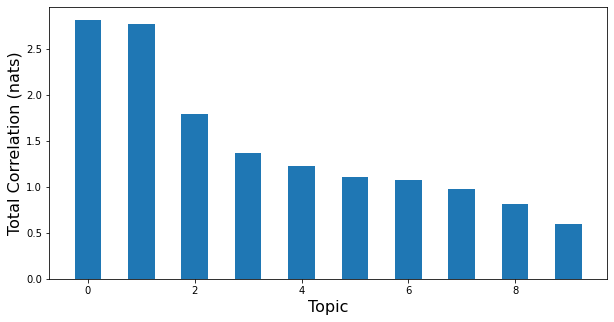

In [23]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
#plt.yscale('log')
#plt.ylim(0.0,0.15)
plt.show();


## CountVectorizer, CorEx, 50 topic model, lower min_df, removed words from vocaulary


In [26]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', \
                            'widescreen', 'studio', 'movie', 'scene', 'effect', 'screenplay'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.001, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=50, words=words, seed=42)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
    

0: base, find, educational, life, love, family, father, young, old, place
1: cartoon, donald, donald duck, mickey mouse, mickey, pluto, silly, symphony, jack hannah, jack kinney
2: animate, premiere, disney, hollywood, short circuit, artist, program, drawing, the walt disney animation studios short circuit, talent
3: theater, open, epcot, pooh, winnie, large, screen, christopher robin, piglet, john fiedler
4: academy award, nominate, academy, award, best, winner, james algar, featurette, narrate, nature
5: picture, world, los angeles, filmmaker, secret, know, country, begin, super, imax
6: touchstone, star, hollywood picture, association, caravan pictures, agent, murder, government, police, husband
7: create, provide, buddy, animal, human, jungle, dog, send, the disney studio, rely
8: washington, business, senior, richard dreyfuss, seemingly, guy, pull, campus, stranger, landscape
9: robert stevenson, reissue, rival, tommy kirk, estate, affection, title, kevin corcoran, oscar, early
10

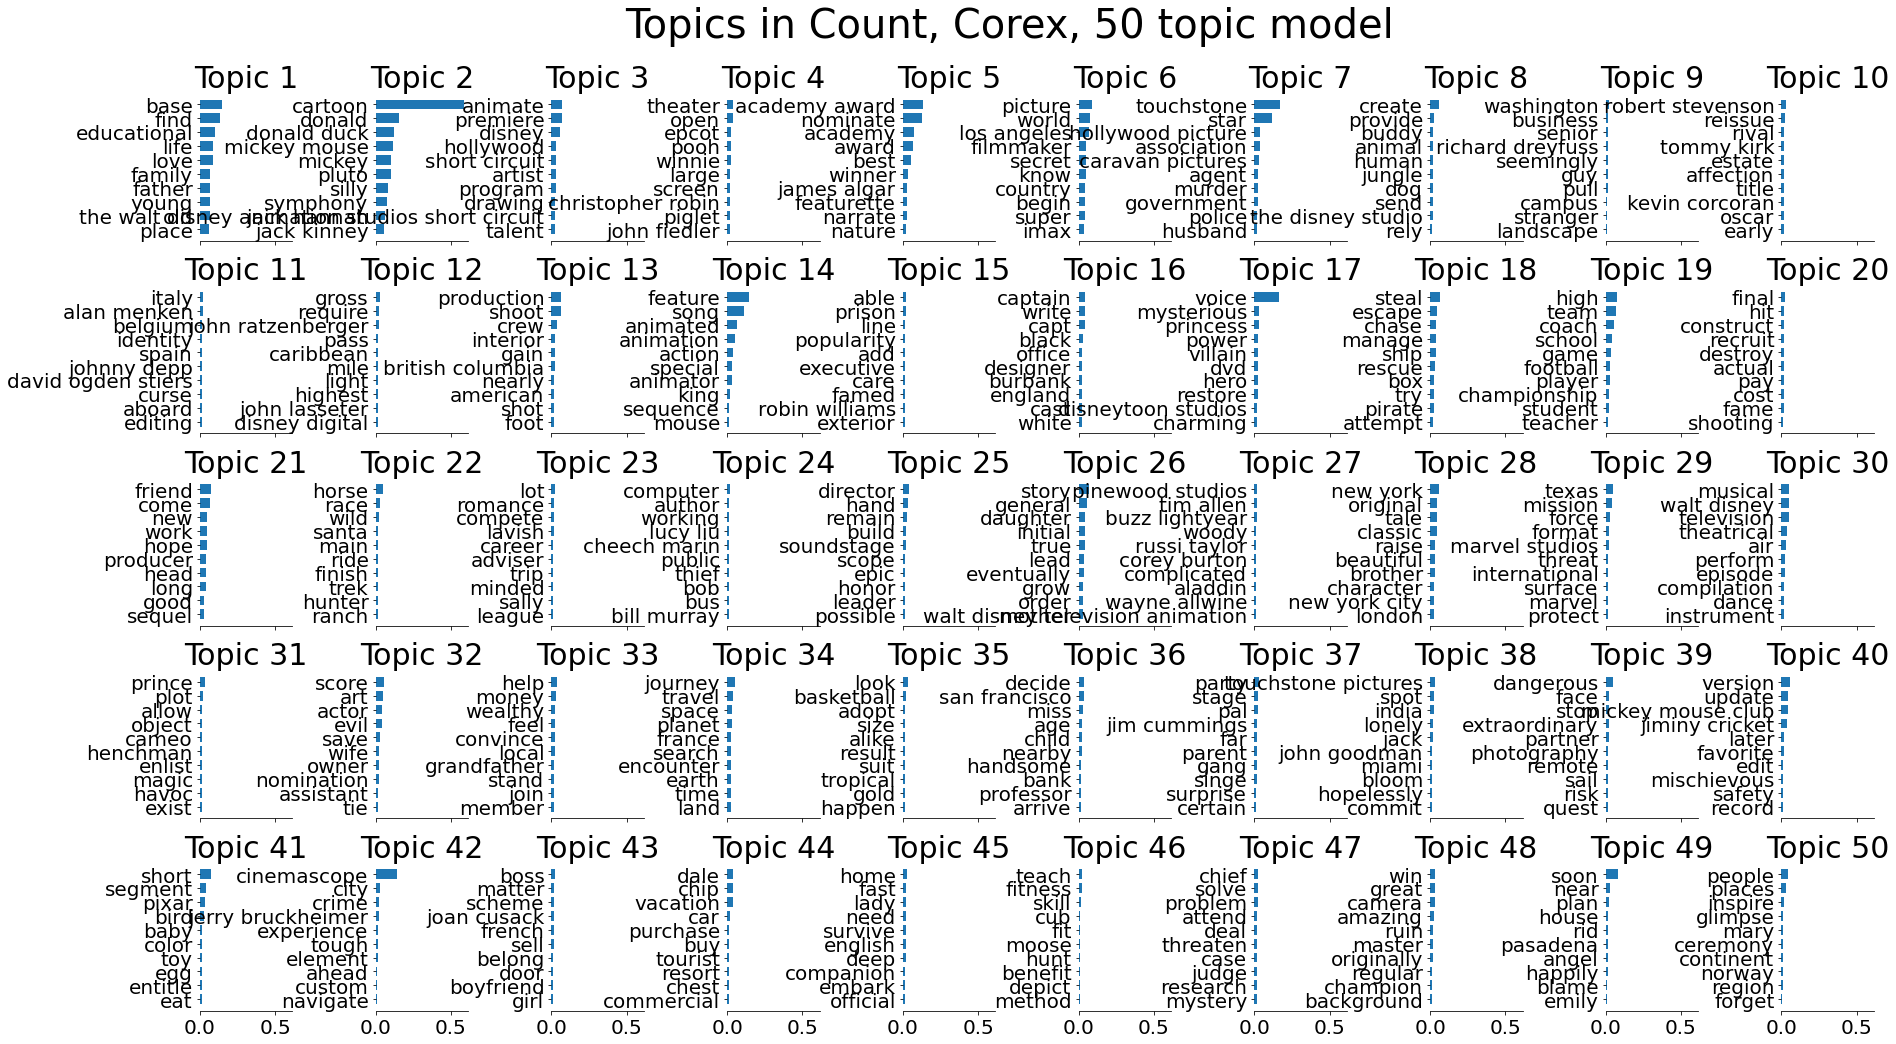

In [27]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, Corex, 50 topic model', rows=5, cols=10)

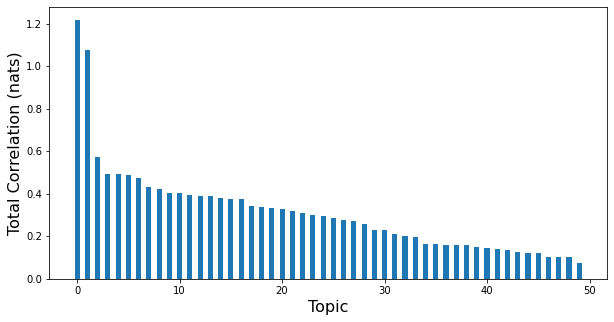

In [29]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
#plt.yscale('log')
#plt.ylim(0.0,0.15)
plt.show();


In [42]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', \
                            'widescreen', 'studio', 'movie', 'scene', 'effect', 'screenplay'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.001, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=20, words=words, seed=42)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
    

0: find, educational, love, discover, father, family, old, world, man, way
1: touchstone, star, picture, new york, los angeles, place, town, association, team, new york city
2: cartoon, donald, donald duck, mickey mouse, mickey, pluto, silly, symphony, jack hannah, wilfred jackson
3: base, song, book, story, original, write, character, create, live, score
4: voice, animate, feature, disney, premiere, animated, dvd, theater, journey, digitally
5: golden, music, robert stevenson, want, prince, capt, add, major, success, alan menken
6: pooh, winnie, john fiedler, piglet, christopher robin, tigger, attack, eeyore, task, fly
7: academy award, nominate, award, academy, best, winner, animation, james algar, animator, receive
8: captain, ship, evil, spectacular, land, agree, visual, charming, military, hero
9: production, general, order, initial, remain, background, cost, hand, hold, entire
10: burbank, the disney studio, white, talent, utilize, soundstage, spirit, head, settle, process
11: li

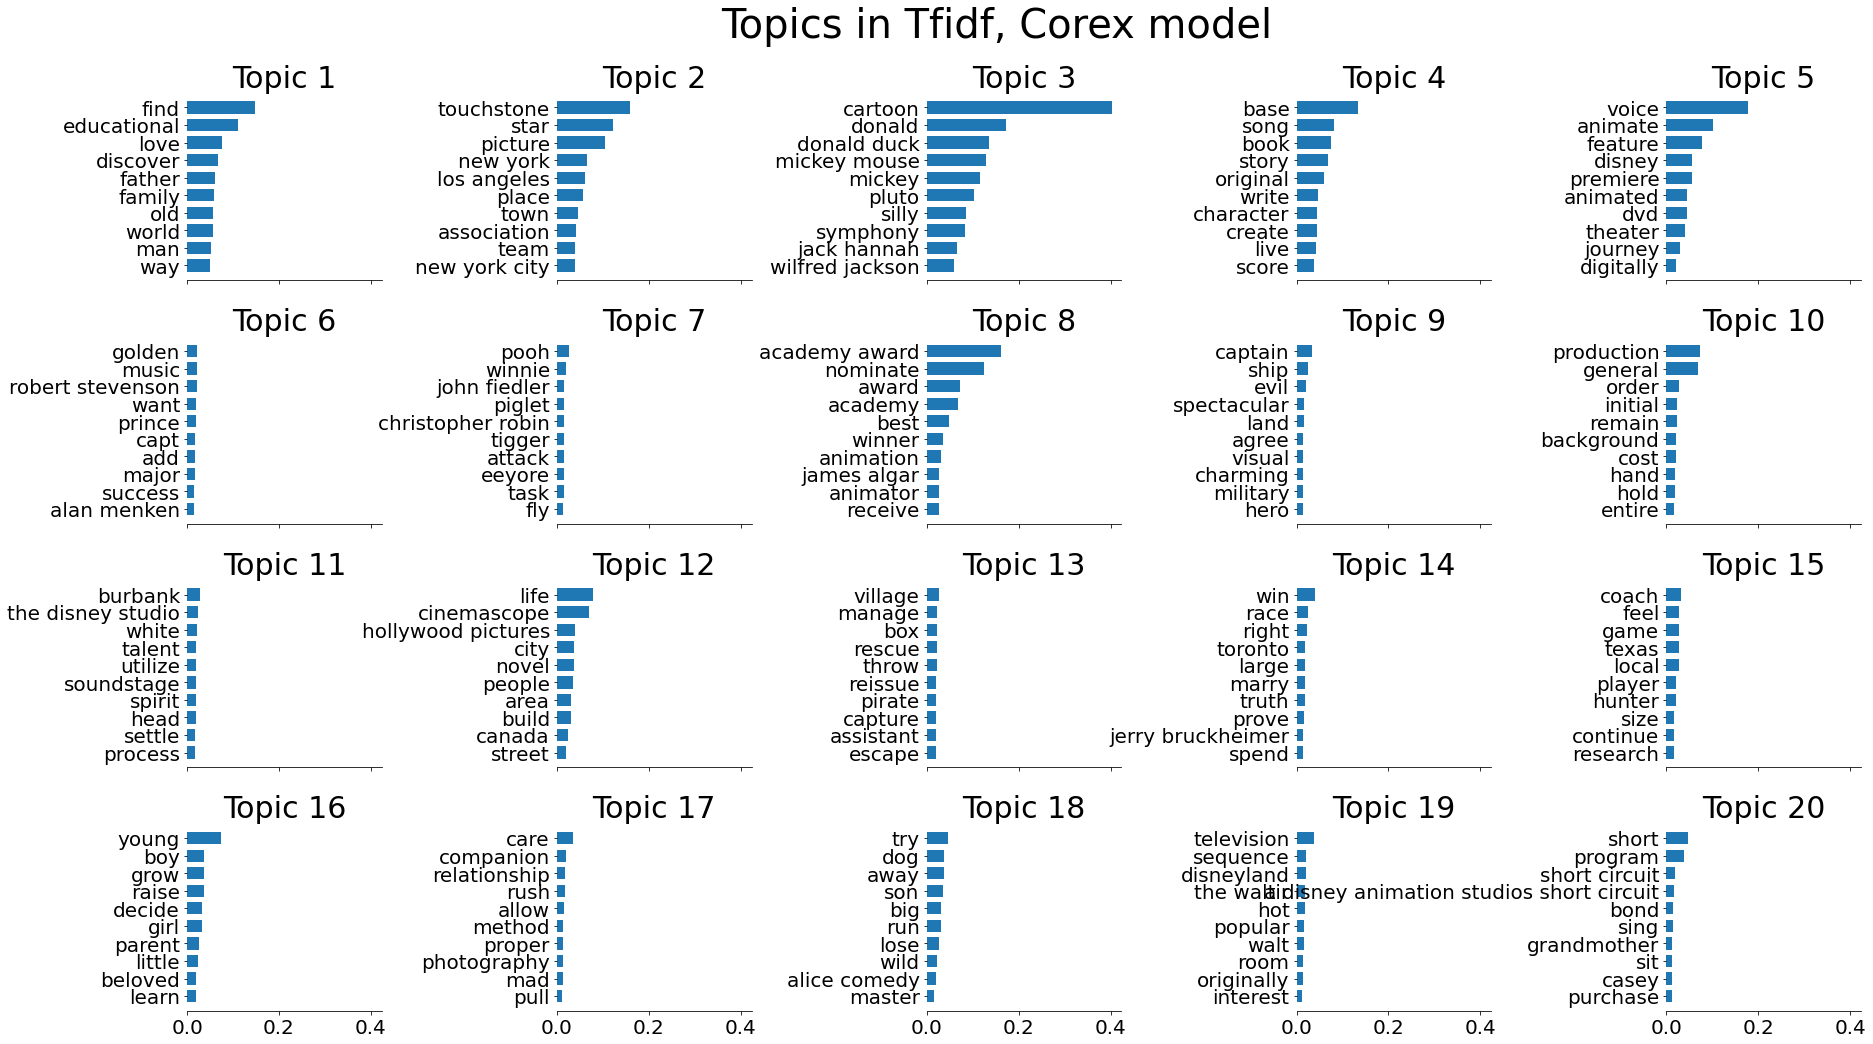

In [43]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Tfidf, Corex model', rows=4, cols=5)


## CountVectorizer, CorEx, 22 topic model with anchor topics


In [67]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', \
                            'widescreen', 'studio', 'movie', 'scene', 'effect', 'screenplay'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.001, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=50, words=words, seed=42,
                         anchors=[['mickey', 'mickey mouse', 'pluto', 'silly', 'symphony'], ['donald', 'donald duck', 'nephew'], ['oswald', 'lucky', 'rabbit'], ['educational'], ['pooh', 'piglet', 'eeyore']], anchor_strength=6)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('Topic {}:'.format(n))
    print(', '.join(topic_words), '\n')
    

Topic 0:
base, find, educational, life, love, family, father, young, old, place 

Topic 1:
cartoon, donald, donald duck, mickey mouse, mickey, pluto, silly, symphony, jack hannah, jack kinney 

Topic 2:
animate, premiere, disney, hollywood, short circuit, artist, program, drawing, the walt disney animation studios short circuit, talent 

Topic 3:
theater, open, epcot, pooh, winnie, large, screen, christopher robin, piglet, john fiedler 

Topic 4:
academy award, nominate, academy, award, best, winner, james algar, featurette, narrate, nature 

Topic 5:
picture, world, los angeles, filmmaker, secret, know, country, begin, super, imax 

Topic 6:
touchstone, star, hollywood picture, association, caravan pictures, agent, murder, government, police, husband 

Topic 7:
create, provide, buddy, animal, human, jungle, dog, send, the disney studio, rely 

Topic 8:
washington, business, senior, richard dreyfuss, seemingly, guy, pull, campus, stranger, landscape 

Topic 9:
robert stevenson, reissue

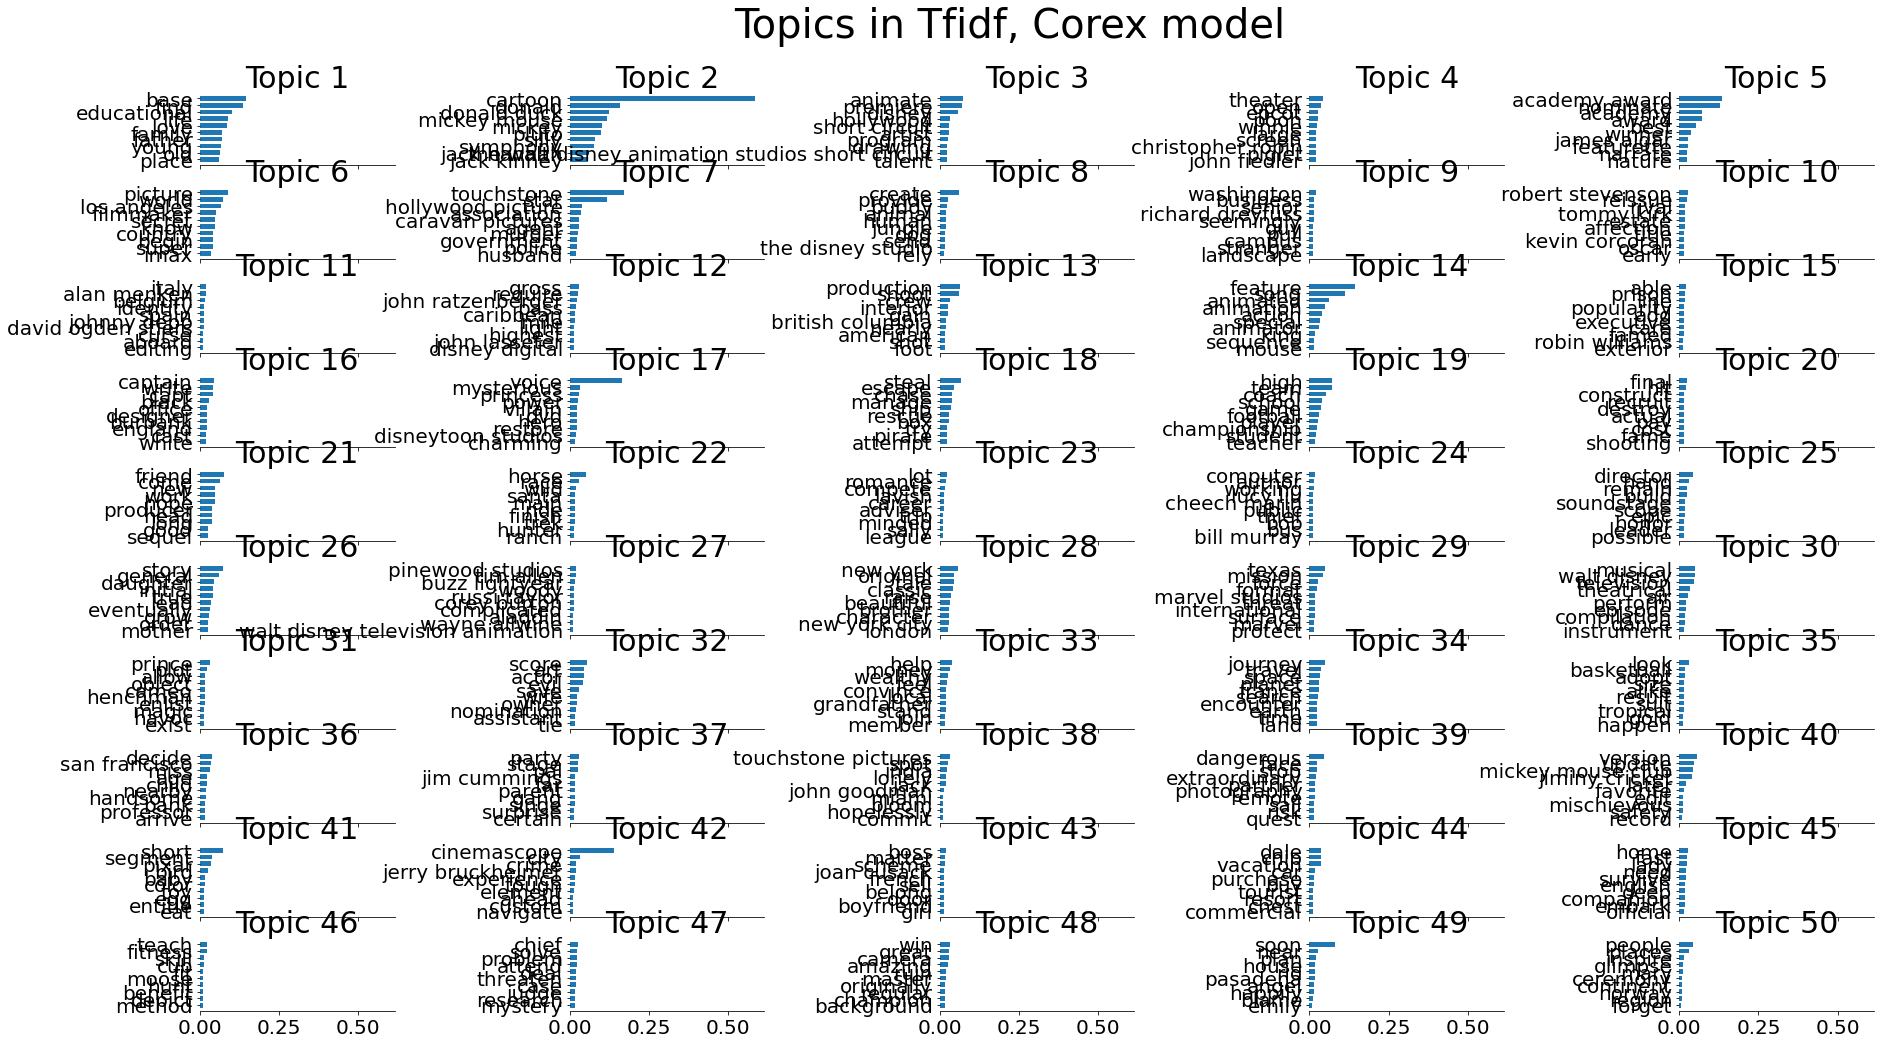

In [70]:
plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Tfidf, Corex model', rows=10, cols=5)


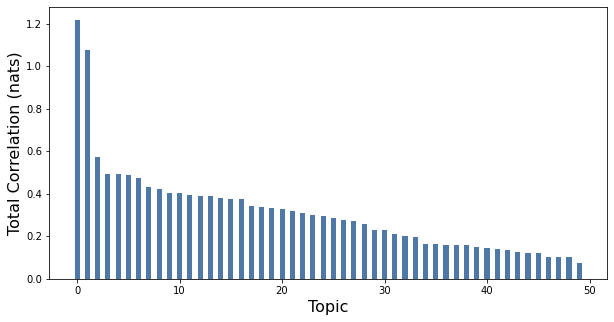

In [69]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show();


In [ ]:
predictions = pd.DataFrame(topic_modeler.predict(doc_word_vectors), columns=['topic'+str(i) for i in range(10)])
predictions.head(5)


In [ ]:
index = 210
doc = df['title'].iloc[index] + '. ' + df['summary'].iloc[index]

test_doc = nlp(doc)

displacy.render(test_doc, style='ent', jupyter=True)


In [ ]:
ent_list = ['DATE', 'CARDINAL', 'ORDINAL', 'MONEY']
        
doc_entities = [ent.text for ent in test_doc.ents if (ent.label_ not in ent_list)]
ignore_ents = [ent.text for ent in test_doc.ents if (ent.label_ in ent_list)]
doc_entities

In [ ]:
pos_list = ['SPACE', 'PUNCT', 'SYM']
doc_tokens = [token for token in test_doc if (not token.is_stop) and (token.pos_ not in pos_list) and (token.text not in ignore_ents)]
doc_tokens

In [ ]:
for t in doc_tokens:
    #print(t, t.pos_, t.lemma_)
    #if t.text in doc_entities:
        #print('named entity')
    #print('\n')
    if t.text in doc_entities:
        t_string = re.sub(f'[{string.punctuation}]+', ' ', t.text).strip().lower()
        print(re.sub(r'\s+', ' ', t_string)) 
    elif t.pos_ == 'PROPN':
        t_string = re.sub(f'[{string.punctuation}]+', ' ', t.text).strip().lower()
        print(re.sub(r'\s+', ' ', t_string))
        
    print('\n')   